## Baseball Stats

In [ ]:
import os
import sqlite3 as sql
import logging

import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats

from scrapers import fangraph
import bb_stat_utils

logging.basicConfig(format='%(asctime)s - %(levelname)s: %(message)s', level=logging.INFO)
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline


In [ ]:
# Point to the SQLLTIE Db
db_path = r'/home/zach/dev/demos/2021_Baseball_PURE.db'
if not os.path.exists(db_path):
    #This may take a while (~30 mins)
    fangraphscraper = fangraph.FangraphScraper(db_path)
    fangraphscraper.generate_sqllite_tables()
conn = sql.connect(db_path)

In [ ]:
df = pd.read_sql('SELECT BO, RBI, PA FROM BAT WHERE "POS"!="P" AND "POS"!="PH" AND PA!=0', con = conn)
df = df.astype(int)

In [ ]:
fgi, ax = plt.subplots(figsize=(16,9))
sns.boxenplot(data=df, x='BO', y='PA', ax=ax)
ax.grid()

g = sns.FacetGrid(df, col="BO", height=2.5, col_wrap=3)
g.map(sns.histplot, "PA")
[i.grid(True) for i in g.axes];

In [ ]:
# KS Test For Normality
for i in np.arange(1000, 10000, 1000):
    rvs = stats.norm.rvs(size=i)
    f = stats.kstest(rvs, "norm")
    print(i, f.pvalue)

In [ ]:
# LOOKS PROMSING
dist_df = df[['PA', 'BO']].groupby('BO').describe()
idx = pd.IndexSlice
x = np.random.normal(*dist_df.loc[:, idx['PA', ['mean', 'std']]].values.T,size=(10000,9))
cont_df = pd.DataFrame(x,columns=range(1,10))
flat_cont_df = cont_df.melt(var_name='BO',value_name='PA')

In [ ]:
fgi, ax = plt.subplots(figsize=(16,9))
sns.boxplot(data=flat_cont_df, x='BO', y='PA', ax=ax)
ax.grid()

g = sns.FacetGrid(flat_cont_df, col="BO", height=2.5, col_wrap=3)
g.map(sns.histplot, "PA")
[i.grid(True) for i in g.axes];

1 0.0
2 0.0
3 0.0
4 0.0
5 0.0
6 0.0
7 0.0
8 0.0
9 1.3279476603165905e-273


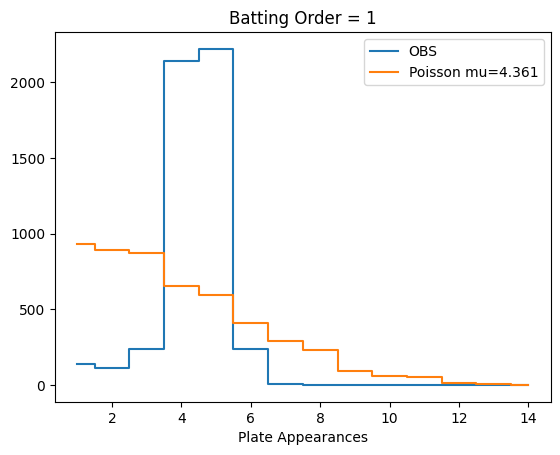

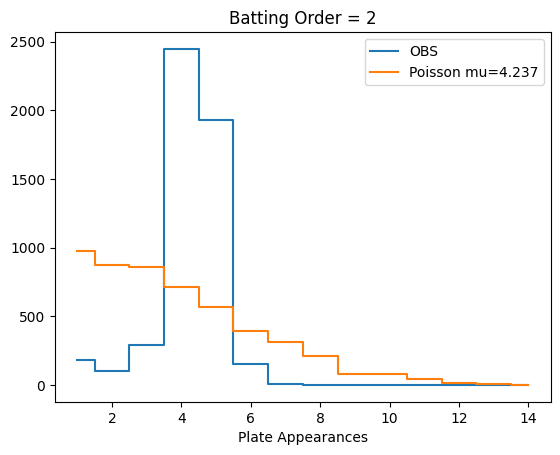

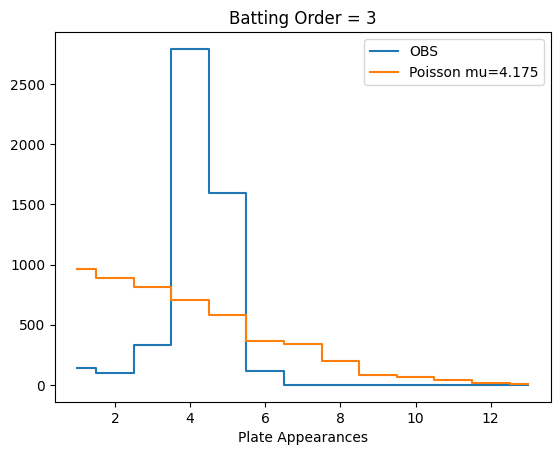

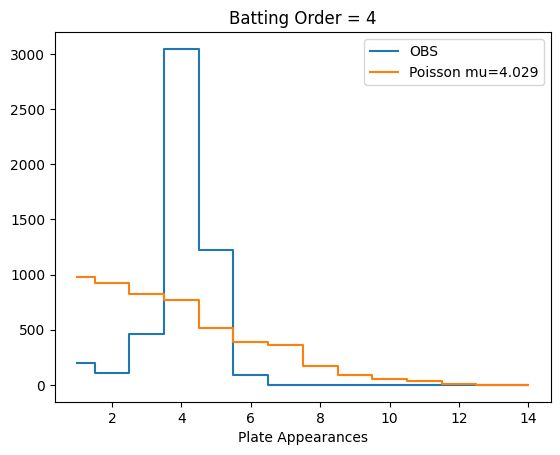

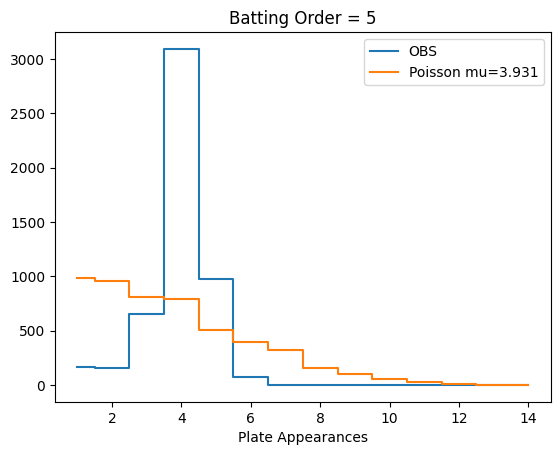

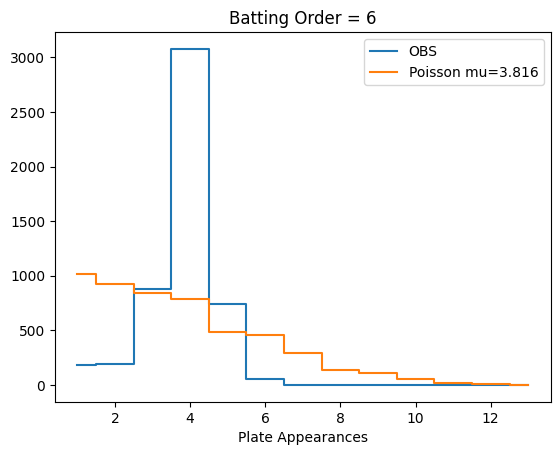

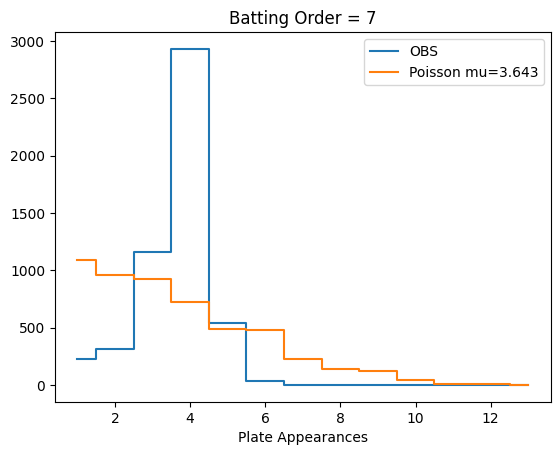

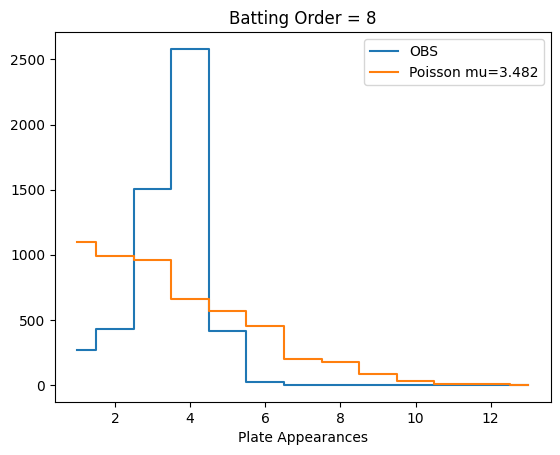

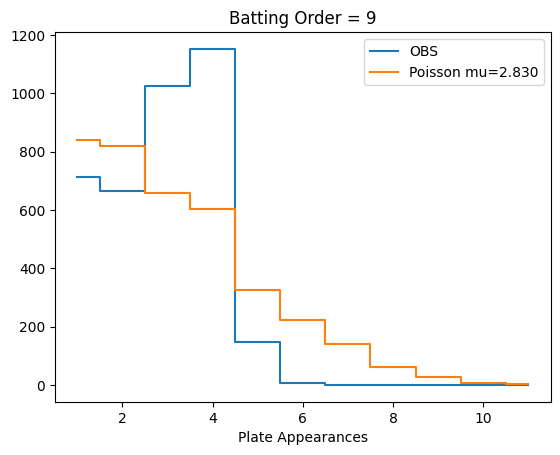

In [136]:
# POISON DOESNT MODEL IT WELL
dfg_obs_counts = df.groupby(['BO'])['PA'].value_counts() 
dfg_obs_mean = df.groupby(['BO'])['PA'].mean() 


df

for i in range(1, 10): 
    obs = dfg_obs_counts.loc[idx[i,:]].sort_index().values
    obs_index = dfg_obs_counts.loc[idx[i,:]].sort_index().index.values

    # Sample a Poisson Distro as Defined by Sample Mean (Mu)
    mu = dfg_obs_mean.loc[i]
    rvs = stats.poisson.rvs(dfg_obs_mean.loc[i], loc=1, size=np.sum(obs), random_state=1)
    rv_counts = pd.value_counts(rvs).values

    # Need to Add 0s to Observed Data, To account for points the model outputs but were not measured
    obs_index_extended = np.arange(1, len(rv_counts) + 1, 1, dtype=int)
    obs_extended = obs_index_extended * 0 
    obs_extended[0:len(obs_index)] = obs

    # Goodness of Fit
    f = stats.chisquare(f_obs=obs_extended, f_exp=rv_counts)
    print(i, f.pvalue)
    
    plt.figure()
    plt.title(f'Batting Order = {i}')
    plt.step(obs_index_extended, obs_extended, where='mid', label='OBS')
    plt.step(obs_index_extended, rv_counts, where='mid', label=f'Poisson mu={mu:2.3f}')
    plt.xlabel('Plate Appearances')
    plt.legend()

In [ ]:
    rvs = stats.poisson.rvs(dfg_obs_mean.loc[i], loc=0, size=1000, random_state=None)
    obs_index = dfg_obs_counts.loc[idx[i,:]].sort_index().index.values
    print(pd.value_counts(rvs).loc[obs_index])

In [ ]:
obs_index = dfg_obs_counts.loc[idx[i,:]].sort_index().index.values